In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.03, count_rollouts: 1, reward: 0.30343987839520203, node: COc1cc(CC(=O)NCCN(CC)C(=O)c2ccc(C)cc2)ccc1C
1- time: 0.45, count_rollouts: 8, reward: 0.09759832796637932, node: S=C(Cn1ccnc1)N[C@@H]1CCCOC1
2- time: 0.71, count_rollouts: 14, reward: 0.44131284104889396, node: S=C(Cc1ccccc1)N(C(=O)Nc1cc(Cl)cnc1)c1ccccn1
3- time: 0.78, count_rollouts: 15, reward: 0.38166748147223684, node: SC[C@H](NCc1ccccc1)C(=O)Nc1ccc(Cl)cc1Cl
4- time: 0.83, count_rollouts: 16, reward: 0.36484192927751996, node: Sc1cc([C@@H]2CN(C(=O)CC(C)C)C2)ccc1C1CC1
5- time: 1.00, count_rollouts: 19, reward: 0.14979233725797317, node: N#Cc1cccc(NC(=O)C(=O)N2CCCCC2)c1
6- time: 1.55, count_rollouts: 31, reward: 0.37785069820614375, node: SN(Cc1ccc(Cl)cc1OCc1ccccc1)C(=O)N1CCOC1
7- time: 1.66, count_rollouts: 33, reward: 0.4425922785378823, node: SOc1ccccc1-c1ccc(OC(C)(C)C)cc1
8- time: 1.81, count_rollouts: 36, reward: 0.22265702658402567, node: OCCCCN1CCCN(C(=O)Cc2ccn3cc(C(C)C)cc3n2)C1
9- time: 2.

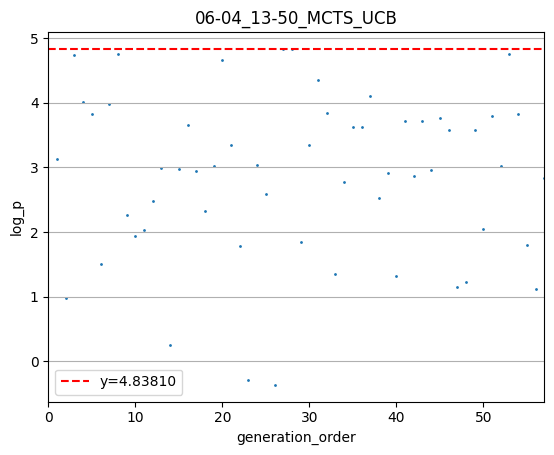

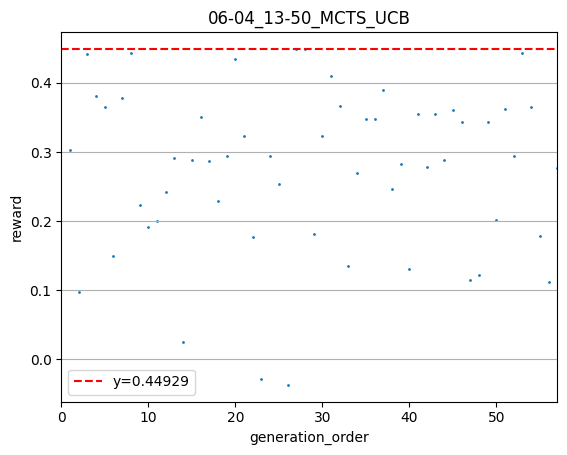

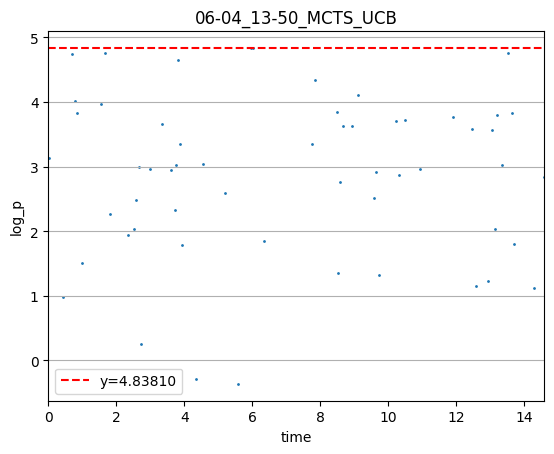

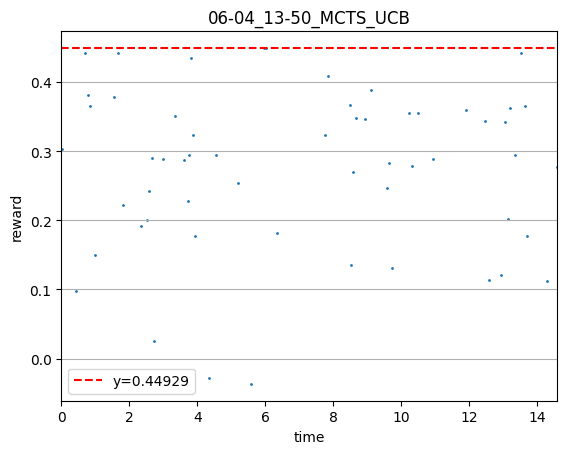

Search is completed.


In [18]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)